# Predicting Surface Roughness (Ra) - Data Acquisition & EDA

This notebook focuses on loading the raw CNC machining dataset, performing initial data quality checks, and conducting exploratory data analysis to understand the relationships between machining parameters and surface roughness.


# Predicting Surface Roughness (Ra): Data Loading & Exploratory Data Analysis

### Project Overview

This is the initial notebook for a data science project aimed at predicting **Surface Roughness (Ra)** in **CNC machining operations**. The primary goal is to develop a predictive model that can identify optimal machining parameter combinations to achieve a desired Ra, thereby reducing manufacturing scrap and streamlining production processes.

### Notebook Objective

This specific notebook focuses on:
1.  **Data Acquisition:** Load dataset.
2.  **Initial Data Inspection:** Perform checks for data quality, missing values, and duplicates.
3.  **Exploratory Data Analysis (EDA):** Examine data through visualizations and statistical summaries to understand:
    * The distribution of the target variable (`Ra`).
    * The distributions of input machining parameters.
    * The relationships between input parameters and `Ra`.
    * Overall data patterns and potential insights for feature engineering and modeling.

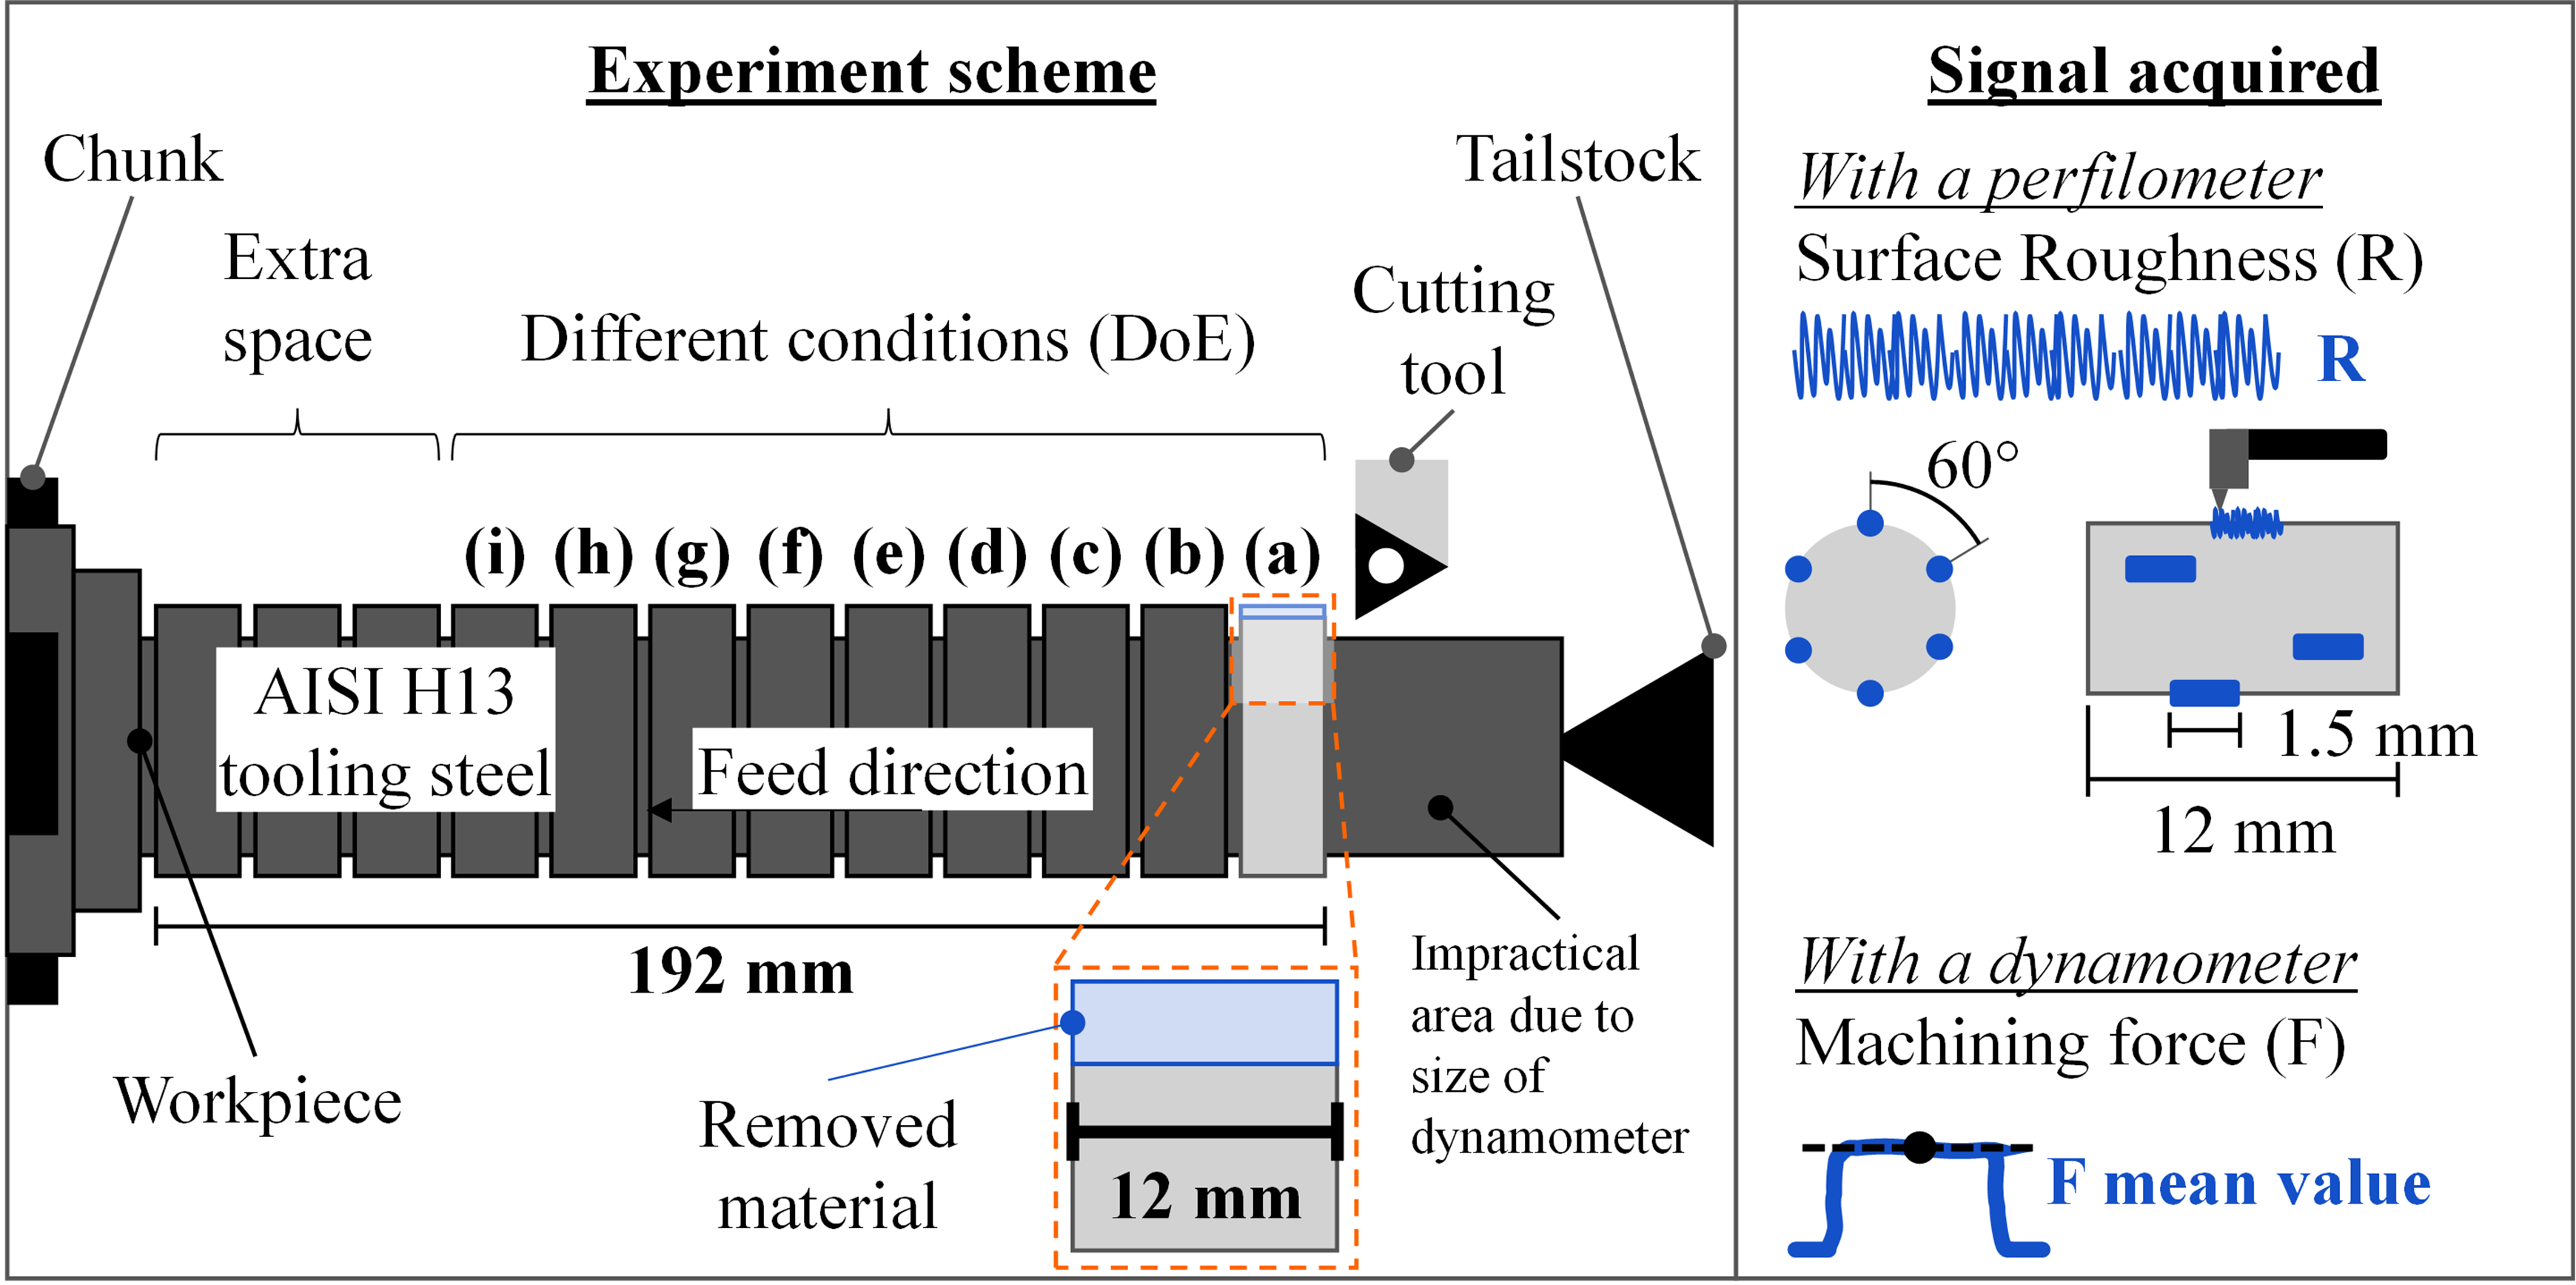

In [1]:
from IPython.display import Image
Image(filename='VWjzBJl.png')

### Setup & Imports 

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib


# Feature Engineering and Preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV # Will use later, but good to have
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer, mean_absolute_percentage_error
import numpy as np
import warnings
from scipy.optimize import minimize

### Data Loading

source: [Kaggle](https://www.kaggle.com/datasets/adorigueto/cnc-turning-roughness-forces-and-tool-wear/data)

In [3]:
file_paths = [R"E:\Data\CNC\Ra\Exp1.csv",
              R"E:\Data\CNC\Ra\Exp2.csv"]

# Load Data
df_list = []
for path in file_paths:
    if os.path.exists(path):
        try:
            df = pd.read_csv(path)
            print(f"Data loaded successfully from: {path}")
            print(f"dataset shape: {df.shape}")
            df_list.append(df)
        except Exception as e:
            print(f"Found '{path}' but failed to load")
            continue

# File was not Found
if df is None:
    print("Error: data files were found.")
    print("Place dataset in the appropriate directory.")

# Merge into a single DataFrame
if df_list:
    merged_df = pd.concat(df_list, ignore_index=True)
    print(f"\nMerged DataFrame shape: {merged_df.shape}")
else:
    print("No data loaded. Please check file formats or paths.")

Data loaded successfully from: E:\Data\CNC\Ra\Exp1.csv
dataset shape: (324, 27)
Data loaded successfully from: E:\Data\CNC\Ra\Exp2.csv
dataset shape: (288, 27)

Merged DataFrame shape: (612, 27)


### Initial Data Inspection & Quality Checks

In [4]:
print("\033[1m"+"\n--- First 5 rows of the dataset ---"+"\033[0m")
print(merged_df.head())
print("\n"*3)

print("\033[1m"+"\n--- Dataset Info  ---"+"\033[0m")
merged_df.info()
print("\n"*3)

print("\033[1m"+"\n--- Statistical Summary of Numerical Columns ---"+"\033[0m")
print(merged_df.describe().T) # .T (transpose) makes it easier to read for many columns
print("\n")


print("\033[1m"+"\n--- Missing Values  ---"+"\033[0m")
missing_values = merged_df.isnull().sum()
print(missing_values[missing_values > 0])
if missing_values.sum() == 0:
    print("No missing values found in the dataset.")
    print("\n")
    
print("\033[1m"+"\n--- Duplicate Rows Check ---"+"\033[0m")
num_duplicates = merged_df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")
if num_duplicates > 0:
    print(f"Dropping {num_duplicates} duplicate rows...")
    print("\n")
    df.drop_duplicates(inplace=True)
    print(f"New dataset shape after dropping duplicates: {df.shape}")
    print("\n")
else:
    print("No duplicate rows found.")
    print("\n")




--- First 5 rows of the dataset ---
         Run_ID  Experiment  Replica  Tool_ID  Group Subgroup Position  \
0  1_021_B1_4_a           1        1       21      1        2        a   
1  1_021_B1_4_a           1        1       21      1        2        a   
2  1_021_B1_4_a           1        1       21      1        2        a   
3  1_021_B1_4_a           1        1       21      1        2        a   
4  1_021_B1_4_a           1        1       21      1        2        a   

   Condition  TCond  Machined_length  ...     Ra     Rz    Rsk    Rku   RSm  \
0          4    0.0               12  ...  0.391  1.855  0.560  2.423  71.4   
1          4    0.0               12  ...  0.359  1.670  0.530  2.229  70.9   
2          4    0.0               12  ...  0.421  1.912  0.634  2.332  71.2   
3          4    0.0               12  ...  0.450  1.961  0.676  2.325  72.8   
4          4    0.0               12  ...  0.360  1.782  0.714  2.636  69.4   

      Rt     Fx     Fy     Fz          F  


### Key Observations from the Data

* **Machining Length is Fixed**: Every experiment ran for the exact same length of 12 units. This is great because it means we don't have to worry about length influencing our results; it's a controlled factor.
* **Diverse Tools and Conditions**: The data includes a wide variety of Tool IDs, Groups, and experimental Conditions. This tells us the study explored many different setups and tool types, which is good for understanding their impact.
* **Surface Roughness Varies a Lot**: Measurements like Ra, Rz, and Rt show a lot of spread, indicating that the machining settings have a big effect on these variables.
* **Forces Aren't Constant**: The forces measured during machining (Fx, Fy, Fz, and the total force F), like Surface Roughness, also vary. As expected, since difference in cutting parameters will lead to different forces.
* **Cutting Speed and Feed Rate are Stable**: The cutting speed (vc) and feed rate (f) seem to be held within relatively narrow ranges. This implies that limited values were chosen for these settings across the experiments.


In [5]:
# Drop the specified columns
# To align with our project's goal of predicting `Surface_Roughness_Ra` solely from controllable machining parameters
columns_to_drop = [
    'Run_ID', 'Experiment', 'Replica', 'Tool_ID', 'Group', 'Subgroup', 'Position', 'Cond', 
    'Machined_length', 'Init_diameter', 'Final_diameter', 'CTime', 'R_measurement',
    'Rz', 'Rsk', 'Rku', 'RSm', 'Rt', 'Condition'
    
]

# Drop the specified columns
# Use errors='ignore' in case some columns were not present (e.g., if you run this multiple times)
merged_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [6]:
# Rename columns  
rename_mapping = {
    'ap': 'Depth_of_Cut_ap',       
    'vc': 'Cutting_Speed_vc',
    'f': 'Feed_Rate_f',
    'Ra': 'Surface_Roughness_Ra',    
    'TCond': 'Tool_Wear'

}

# Apply renaming only to columns that exist in the DataFrame
merged_df.rename(columns={k: v for k, v in rename_mapping.items() if k in merged_df.columns}, inplace=True)


merged_df.head()

,Tool_Wear,Depth_of_Cut_ap,Cutting_Speed_vc,Feed_Rate_f,Surface_Roughness_Ra,Fx,Fy,Fz,F
0,0.0,0.25,350,0.07,0.391,49.23,44.46,21.07,69.600499
1,0.0,0.25,350,0.07,0.359,49.23,44.46,21.07,69.600499
2,0.0,0.25,350,0.07,0.421,49.23,44.46,21.07,69.600499
3,0.0,0.25,350,0.07,0.450,49.23,44.46,21.07,69.600499
4,0.0,0.25,350,0.07,0.360,49.23,44.46,21.07,69.600499


In [7]:

# Plots display options 
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000)        

# plots style and color palette 
plt.style.use('fivethirtyeight')      
sns.set_palette('crest')                  

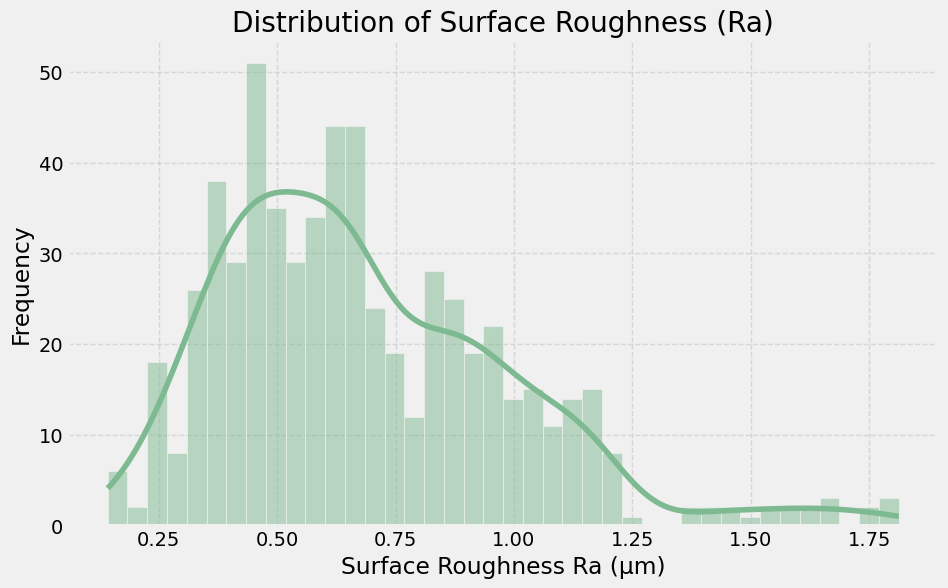

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['Surface_Roughness_Ra'], kde=True, bins=40)
plt.title('Distribution of Surface Roughness (Ra)')
plt.xlabel('Surface Roughness Ra (µm)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


### Key Observations
Most the values fall between ~0.4 and ~0.8 μm. Which means our model may be able to predict well within that range but might struggle anywhere.

there is a right-skewed distribution, this can affect regression models that assume a normal distribution and might lead to biased predictions or overemphasis on outliers unless addressed.

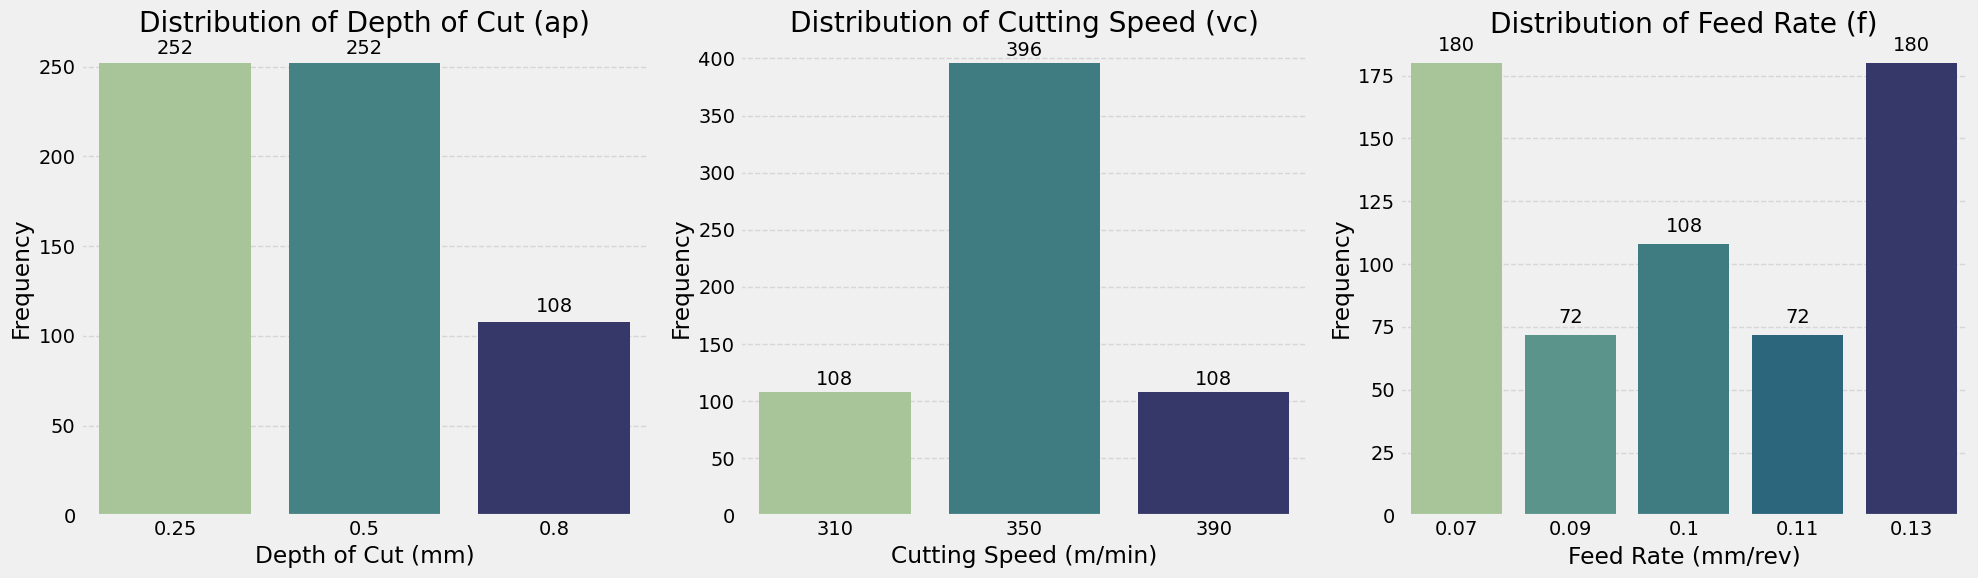

In [9]:
# --- Univariate Analysis: Count Plots for Discrete Parameters with Counts ---

fig, axes = plt.subplots(1, 3, figsize=(20, 6)) # Slightly increased width for better label spacing

# Loop through each parameter to create its count plot and add counts
parameters = ['Depth_of_Cut_ap', 'Cutting_Speed_vc', 'Feed_Rate_f']
x_labels = ['Depth of Cut (mm)', 'Cutting Speed (m/min)', 'Feed Rate (mm/rev)']
titles = ['Distribution of Depth of Cut (ap)', 'Distribution of Cutting Speed (vc)', 'Distribution of Feed Rate (f)']

for i, param in enumerate(parameters):
    ax = axes[i]
    sns.countplot(x=param, data=merged_df, ax=ax, palette='crest',hue=param, legend=False)
    ax.set_title(titles[i])
    ax.set_xlabel(x_labels[i])
    ax.set_ylabel('Frequency')
    ax.grid(axis='y', linestyle='--', alpha=0.7) # Grid on y-axis only

    # Add count labels on top of each bar
    for container in ax.containers: # ax.containers holds the BarContainer object
        # container.patches is a list of Rectangle objects (the bars)
        for patch in container.patches:
            height = patch.get_height()
            ax.text(patch.get_x() + patch.get_width() / 2., # x-coordinate of the text
                    height + 3, # y-coordinate (height + a small offset)
                    f'{int(height)}', # The text to display (integer count)
                    ha='center', va='bottom') # Horizontal and vertical alignment

plt.tight_layout()
plt.show()

C:\Users\santo\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


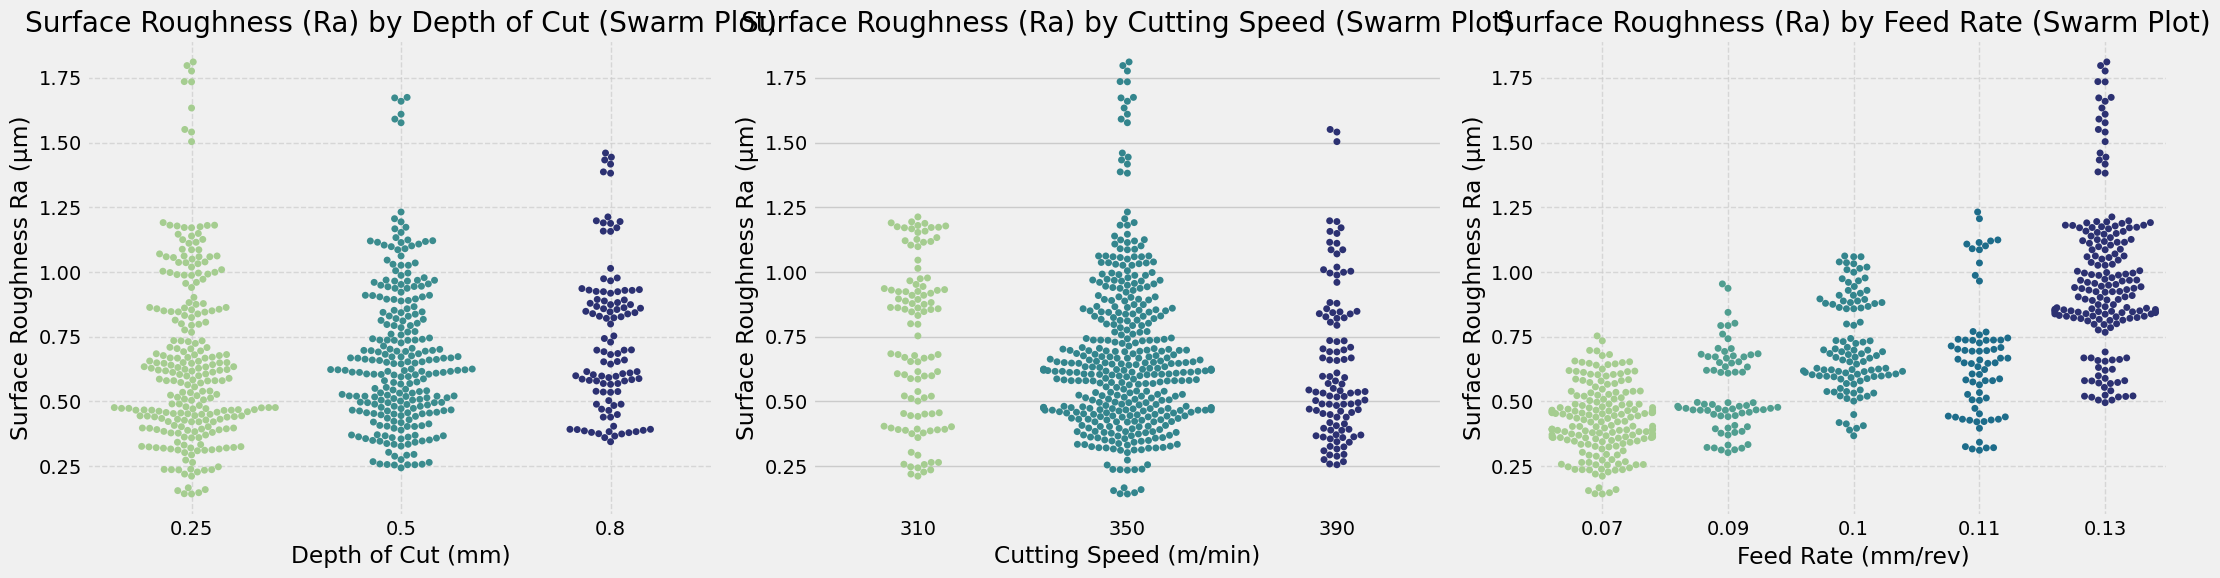

In [10]:
# --- Plots with Swarm Plots ---
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# Ra vs. Depth of Cut with Swarm Plot
sns.swarmplot(x='Depth_of_Cut_ap', y='Surface_Roughness_Ra', data=merged_df, ax=axes[0], hue='Depth_of_Cut_ap', palette='crest', s=5, legend=False)
axes[0].set_title('Surface Roughness (Ra) by Depth of Cut (Swarm Plot)')
axes[0].set_xlabel('Depth of Cut (mm)')
axes[0].set_ylabel('Surface Roughness Ra (µm)')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Ra vs. Cutting Speed with Swarm Plot
sns.swarmplot(x='Cutting_Speed_vc', y='Surface_Roughness_Ra', data=merged_df, ax=axes[1], hue='Cutting_Speed_vc', palette='crest', s=5, legend=False)
axes[1].set_title('Surface Roughness (Ra) by Cutting Speed (Swarm Plot)')
axes[1].set_xlabel('Cutting Speed (m/min)')
axes[1].set_ylabel('Surface Roughness Ra (µm)')

# Ra vs. Feed Rate with Swarm Plot
sns.swarmplot(x='Feed_Rate_f', y='Surface_Roughness_Ra', data=merged_df, ax=axes[2],hue='Feed_Rate_f', palette='crest', s=5, legend=False)
axes[2].set_title('Surface Roughness (Ra) by Feed Rate (Swarm Plot)')
axes[2].set_xlabel('Feed Rate (mm/rev)')
axes[2].set_ylabel('Surface Roughness Ra (µm)')
axes[2].grid(True, linestyle='--', alpha=0.7)


warnings.filterwarnings("ignore", category=UserWarning)
plt.tight_layout()
plt.show()

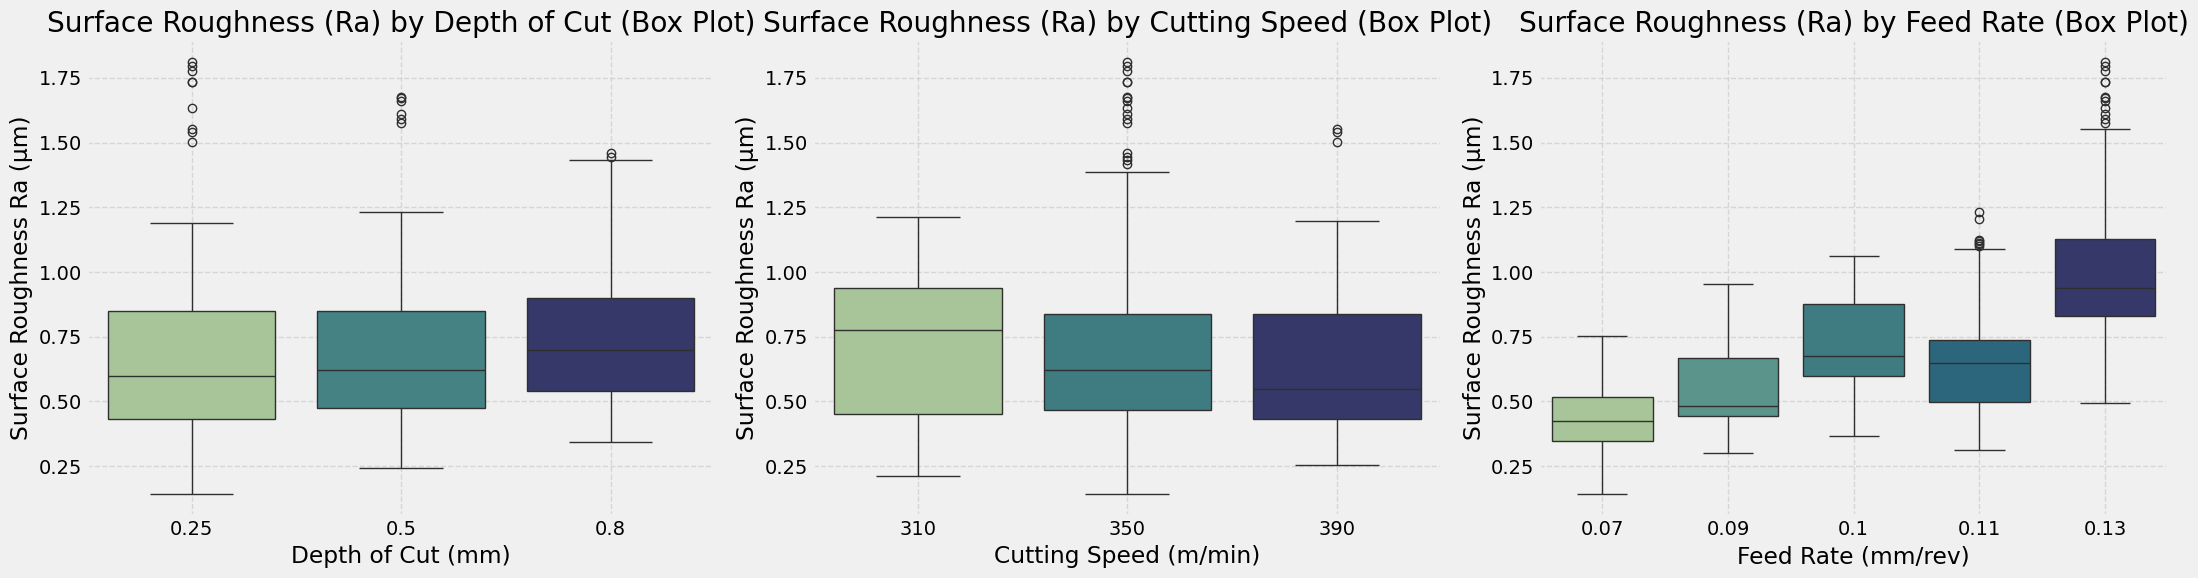

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# Ra vs. Depth of Cut with Box Plot
sns.boxplot(x='Depth_of_Cut_ap', y='Surface_Roughness_Ra', data=merged_df, ax=axes[0], hue='Depth_of_Cut_ap', palette='crest', legend=False)
axes[0].set_title('Surface Roughness (Ra) by Depth of Cut (Box Plot)')
axes[0].set_xlabel('Depth of Cut (mm)')
axes[0].set_ylabel('Surface Roughness Ra (µm)')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Ra vs. Cutting Speed with Box Plot
sns.boxplot(x='Cutting_Speed_vc', y='Surface_Roughness_Ra', data=merged_df, ax=axes[1], hue='Cutting_Speed_vc', palette='crest', legend=False)
axes[1].set_title('Surface Roughness (Ra) by Cutting Speed (Box Plot)')
axes[1].set_xlabel('Cutting Speed (m/min)')
axes[1].set_ylabel('Surface Roughness Ra (µm)')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Ra vs. Feed Rate with Box Plot
sns.boxplot(x='Feed_Rate_f', y='Surface_Roughness_Ra', data=merged_df, ax=axes[2], hue='Feed_Rate_f', palette='crest', legend=False)
axes[2].set_title('Surface Roughness (Ra) by Feed Rate (Box Plot)')
axes[2].set_xlabel('Feed Rate (mm/rev)')
axes[2].set_ylabel('Surface Roughness Ra (µm)')
axes[2].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

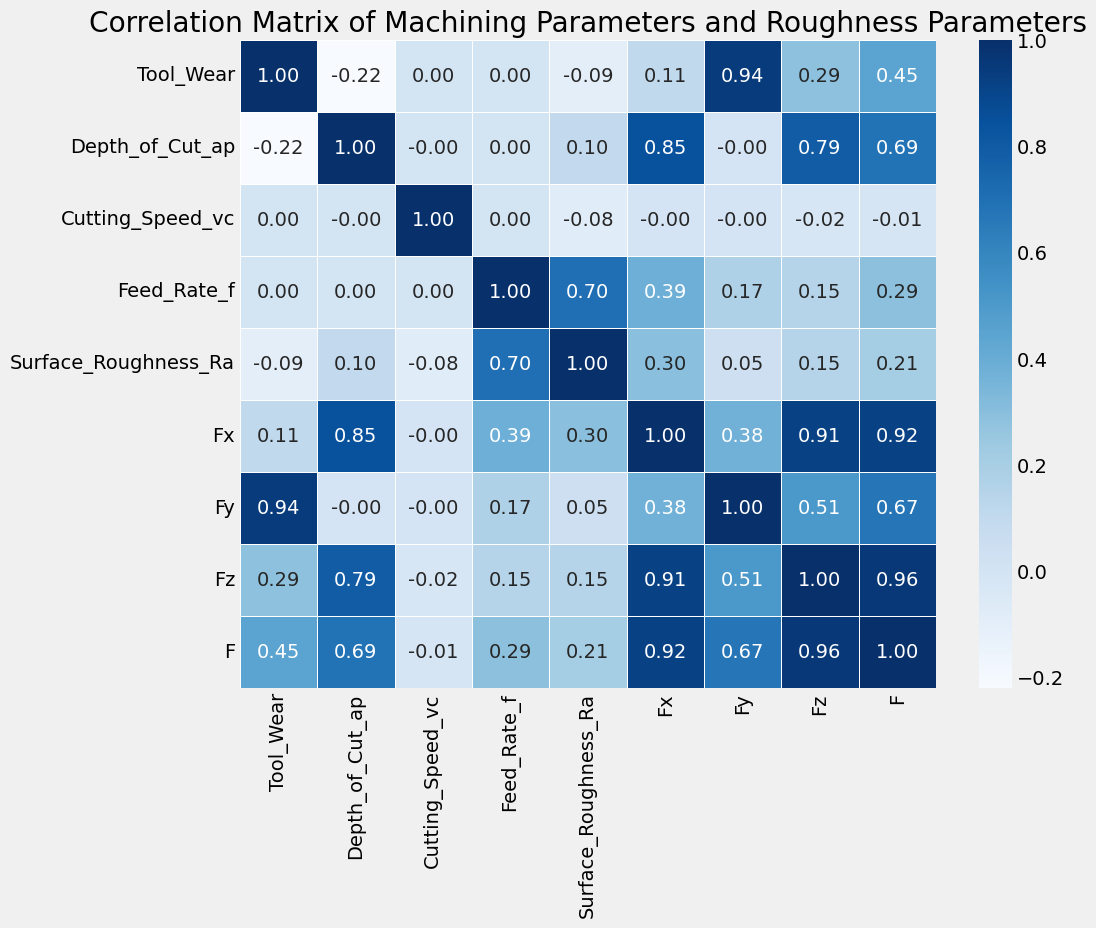

In [12]:
#Correlation Analysis


plt.figure(figsize=(10, 8))
correlation_matrix = merged_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Machining Parameters and Roughness Parameters')
plt.show()

# Correlation Matrix Key Observations:

- Feed Rate (f) is the most influential parameter, showing a direct positive relationship with Surface_Roughness_Ra. This is a critical insight for process control.
- Depth of Cut (ap) and Cutting Speed (vc) appears to have a less direct impact compared to Fx and feed rate

### Data Saving 

In [13]:
merged_df.to_csv('cleaned_data.csv', index=False)



**EDA Summary :**

`Feed_Rate_f` is the most influential parameter to determine `Surface_Roughness_Ra` with `Cutting_Speed_vc` and `Depth_of_Cut_ap` minimal correlation.



In [43]:
merged_df = pd.read_csv("cleaned_data.csv")

In [44]:
merged_df = merged_df.drop(columns=['Fz','Fy','Fx'])

In [45]:
# Define the target variable
target_column = 'Surface_Roughness_Ra'
y = merged_df[target_column]



# Drop the target column to get the feature matrix
X = merged_df.drop(columns=[target_column]).copy()

print(f"Target variable '{target_column}' defined. Shape: {y.shape}")
print(f"Initial features (X) defined. Shape: {X.shape}")
print("\nFirst 5 rows of X:")
print(X.head())

Target variable 'Surface_Roughness_Ra' defined. Shape: (612,)
Initial features (X) defined. Shape: (612, 5)

First 5 rows of X:
   Tool_Wear  Depth_of_Cut_ap  Cutting_Speed_vc  Feed_Rate_f          F
0        0.0             0.25               350         0.07  69.600499
1        0.0             0.25               350         0.07  69.600499
2        0.0             0.25               350         0.07  69.600499
3        0.0             0.25               350         0.07  69.600499
4        0.0             0.25               350         0.07  69.600499


### Data Scaling

Scaling numerical features is a critical preprocessing step for many machine learning algorithms. While tree-based models (like Random Forest and XGBoost, which we plan to use) are less sensitive to feature scales, scaling is good practice for:


In [46]:
print("\nScaling numerical features using StandardScaler...")

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler to X and transform X
X_scaled = scaler.fit_transform(X)

# Convert the scaled array back to a DataFrame, preserving column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)


print(X_scaled_df.head())


Scaling numerical features using StandardScaler...
   Tool_Wear  Depth_of_Cut_ap  Cutting_Speed_vc  Feed_Rate_f         F
0   -0.57886        -1.011215               0.0    -1.275798 -1.338158
1   -0.57886        -1.011215               0.0    -1.275798 -1.338158
2   -0.57886        -1.011215               0.0    -1.275798 -1.338158
3   -0.57886        -1.011215               0.0    -1.275798 -1.338158
4   -0.57886        -1.011215               0.0    -1.275798 -1.338158


In [47]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Training and Evaluation for Multiple Models

In [48]:



# Define the models to be trained
models = {
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoostRegressor': XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1),
    'KKNeighborsRegressor' : KNeighborsRegressor(n_neighbors=5),

}

for name, model in models.items():
    print(f"\n--- Training and Evaluating {name} ---")



    print(f"Training {name} model...")
    model.fit(X_train, y_train)
    print(f"{name} training complete.")

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"    Mean Absolute Percentage Error (MAPE): {mape:.4f}")
    print(f"  R-squared (R2): {r2:.4f}")



--- Training and Evaluating RandomForestRegressor ---
Training RandomForestRegressor model...
RandomForestRegressor training complete.
  Mean Absolute Error (MAE): 0.0324
  Mean Squared Error (MSE): 0.0032
  Root Mean Squared Error (RMSE): 0.0566
    Mean Absolute Percentage Error (MAPE): 0.0467
  R-squared (R2): 0.9682

--- Training and Evaluating XGBoostRegressor ---
Training XGBoostRegressor model...
XGBoostRegressor training complete.
  Mean Absolute Error (MAE): 0.0322
  Mean Squared Error (MSE): 0.0031
  Root Mean Squared Error (RMSE): 0.0559
    Mean Absolute Percentage Error (MAPE): 0.0463
  R-squared (R2): 0.9690

--- Training and Evaluating KKNeighborsRegressor ---
Training KKNeighborsRegressor model...
KKNeighborsRegressor training complete.
  Mean Absolute Error (MAE): 0.0709
  Mean Squared Error (MSE): 0.0102
  Root Mean Squared Error (RMSE): 0.1010
    Mean Absolute Percentage Error (MAPE): 0.1037
  R-squared (R2): 0.8988


In [49]:
models = {
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
        }
    },
    'XGBoostRegressor': {
        'model': XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
        }
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor(),
        'param_grid': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'p': [1, 2, 3], 
        }
    },
}

# Directory to save the models
model_save_dir = "trained_models/"
import os
os.makedirs(model_save_dir, exist_ok=True)

for name, model_info in models.items():
    print(f"\n--- Training and Evaluating {name} with Grid Search ---")

    model = model_info['model']
    param_grid = model_info['param_grid']

    print(f"Performing Grid Search for {name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, 
                               scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    print(f"{name} Grid Search complete. Best parameters: {grid_search.best_params_}")
    print(f"Training {name} model with best parameters...")
    # The best_model is already fitted by GridSearchCV, so no need to refit
    print(f"{name} training complete (via Grid Search).")

    # Make predictions with the best model
    y_pred = best_model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100 # MAPE calculation
    r2 = r2_score(y_test, y_pred)

    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Mean Absolute Percentage Error (MAPE): {mape:.4f}%") # Changed to percentage
    print(f"  R-squared (R2): {r2:.4f}")


--- Training and Evaluating RandomForestRegressor with Grid Search ---
Performing Grid Search for RandomForestRegressor...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
RandomForestRegressor Grid Search complete. Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Training RandomForestRegressor model with best parameters...
RandomForestRegressor training complete (via Grid Search).
  Mean Absolute Error (MAE): 0.0325
  Mean Squared Error (MSE): 0.0032
  Root Mean Squared Error (RMSE): 0.0563
  Mean Absolute Percentage Error (MAPE): 4.6379%
  R-squared (R2): 0.9686

--- Training and Evaluating XGBoostRegressor with Grid Search ---
Performing Grid Search for XGBoostRegressor...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
XGBoostRegressor Grid Search complete. Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50}
Training XGBoostRegressor model with best parameters...
XGBoostRegressor training complete (vi

In [50]:
for name, model_info in models.items():

    best_model = grid_search.best_estimator_

    # Save the best model
    model_filename = os.path.join(model_save_dir, f"{name.lower()}_best_model.pkl")
    joblib.dump(best_model, model_filename)
    print(f"Best {name} model saved to {model_filename}")

print("\nAll models trained saved.")

Best RandomForestRegressor model saved to trained_models/randomforestregressor_best_model.pkl
Best XGBoostRegressor model saved to trained_models/xgboostregressor_best_model.pkl
Best KNeighborsRegressor model saved to trained_models/kneighborsregressor_best_model.pkl

All models trained saved.


Performing GridSearchCV for RandomForestRegressor...
Fitting 3 folds for each of 216 candidates, totalling 648 fits
GridSearchCV for RandomForestRegressor complete.

--- Results for RandomForestRegressor ---
  Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
  Best Cross-Validation Score (Negative MSE): -0.0057
  (Equivalent Best RMSE): 0.0753
  Test Set Evaluation :
    Mean Absolute Error (MAE): 0.0328
    Mean Squared Error (MSE): 0.0031
    Root Mean Squared Error (RMSE): 0.0561
    Mean Absolute Percentage Error (MAPE): 0.0472
    R-squared (R2): 0.9688

--- Top 10 Feature Importances for RandomForestRegressor ---
F                   0.435269
Feed_Rate_f         0.431643
Cutting_Speed_vc    0.046979
Depth_of_Cut_ap     0.043416
Tool_Wear           0.042693
dtype: float64


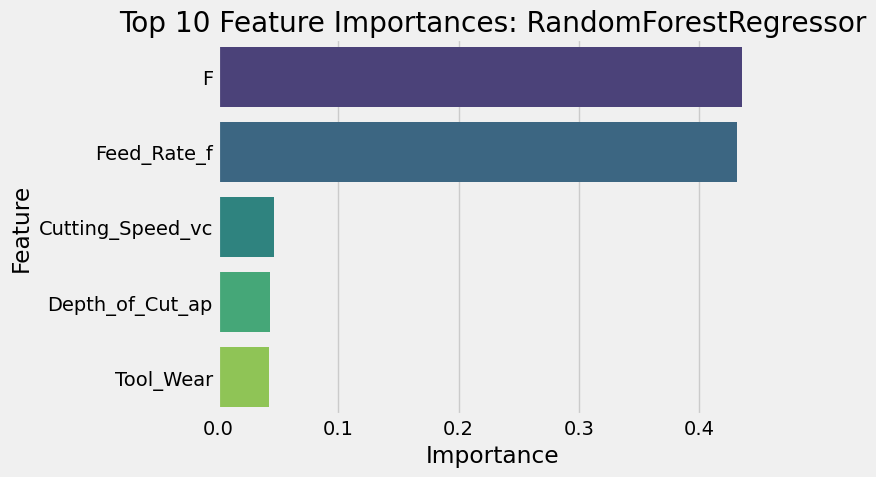

Performing GridSearchCV for XGBoostRegressor...
Fitting 3 folds for each of 324 candidates, totalling 972 fits
GridSearchCV for XGBoostRegressor complete.

--- Results for XGBoostRegressor ---
  Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.6}
  Best Cross-Validation Score (Negative MSE): -0.0055
  (Equivalent Best RMSE): 0.0742
  Test Set Evaluation :
    Mean Absolute Error (MAE): 0.0327
    Mean Squared Error (MSE): 0.0031
    Root Mean Squared Error (RMSE): 0.0561
    Mean Absolute Percentage Error (MAPE): 0.0468
    R-squared (R2): 0.9688

--- Top 10 Feature Importances for XGBoostRegressor ---
Feed_Rate_f         0.566838
F                   0.136469
Tool_Wear           0.110714
Cutting_Speed_vc    0.097940
Depth_of_Cut_ap     0.088039
dtype: float32


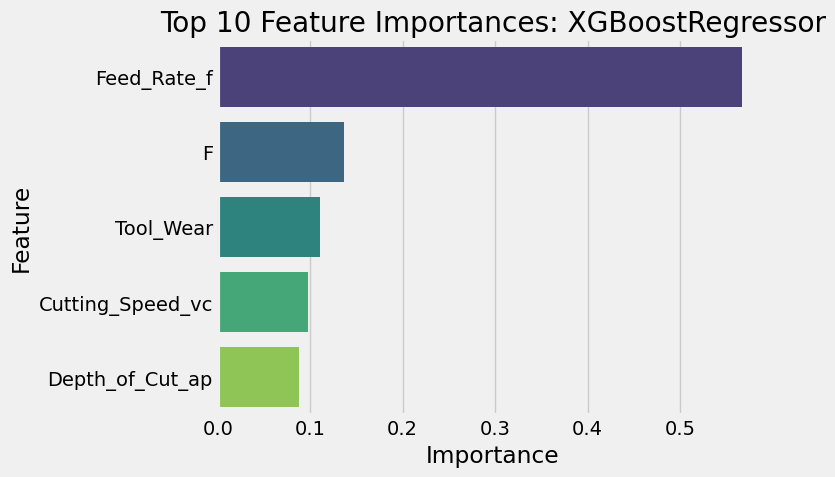

In [51]:
# Define the models and their respective hyperparameter grids
models_and_params = {
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators': [100, 200, 400, 500],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2']
        }
    },
    'XGBoostRegressor': {
        'model': XGBRegressor(random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.3],
            'max_depth': [3, 5, 7, 10],
            'subsample': [0.6,0.7, 1.0],
            'colsample_bytree': [0.6, 0.7, 1.0]
        }
    
    }
}



# Define the scorer. GridSearchCV optimizes based on a scoring metric.
# We'll use negative mean squared error as GridSearchCV aims to maximize scores,
# so negative values allow it to find the minimum MSE.
scorer = make_scorer(mean_squared_error, greater_is_better=False)
feature_names = X.columns.tolist()
for name, config in models_and_params.items():

    # Initialize GridSearchCV directly with the model
    grid_search = GridSearchCV(
        estimator=config['model'], # GridSearchCV will tune this specific model
        param_grid=config['param_grid'],
        scoring=scorer, # Use the defined scorer
        cv=3,
        n_jobs=-1,
        verbose=1 # Prints progress
    )

    print(f"Performing GridSearchCV for {name}...")
    grid_search.fit(X_train, y_train)
    print(f"GridSearchCV for {name} complete.")


    best_model = grid_search.best_estimator_

    print(f"\n--- Results for {name} ---")
    print(f"  Best Parameters: {grid_search.best_params_}")
    print(f"  Best Cross-Validation Score (Negative MSE): {grid_search.best_score_:.4f}")
    print(f"  (Equivalent Best RMSE): {np.sqrt(-grid_search.best_score_):.4f}")

    # Evaluate the best model on test set
    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"  Test Set Evaluation :")
    print(f"    Mean Absolute Error (MAE): {mae:.4f}")
    print(f"    Mean Squared Error (MSE): {mse:.4f}")
    print(f"    Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"    Mean Absolute Percentage Error (MAPE): {mape:.4f}")
    print(f"    R-squared (R2): {r2:.4f}")
    if name in ['RandomForestRegressor', 'XGBoostRegressor']:
        try:
            # Get feature importances 
            feature_importances = best_model.feature_importances_

            importances_df = pd.Series(feature_importances, index=feature_names)
            importances_df = importances_df.sort_values(ascending=False)

            print(f"\n--- Top 10 Feature Importances for {name} ---")
            print(importances_df.head(10))

            # Plot top 10 feature importances
            top_features = importances_df.head(10)
            plt.figure(figsize=(8, 5))
            sns.barplot(x=top_features.values, y=top_features.index, palette='viridis', hue=top_features.index)

            plt.title(f"Top 10 Feature Importances: {name}")
            plt.xlabel("Importance")
            plt.ylabel("Feature")
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"\nCould not determine feature importances for {name}: {e}")
    # --- Feature Importance  ---
   # if name in ['RandomForestRegressor', 'XGBoostRegressor']:
      #  try:
            # Get feature importances 
         #   feature_importances = best_model.feature_importances_

         #   importances_df = pd.Series(feature_importances, index=feature_names)
        #    importances_df = importances_df.sort_values(ascending=False)

         #   print(f"\n--- Top 10 Feature Importances for {name} ---")
         #   print(importances_df.head(10))

        #except Exception as e:
          #  print(f"\nCould not determine feature importances for {name}: {e}")

In [59]:
print(name.type())

AttributeError: 'str' object has no attribute 'type'

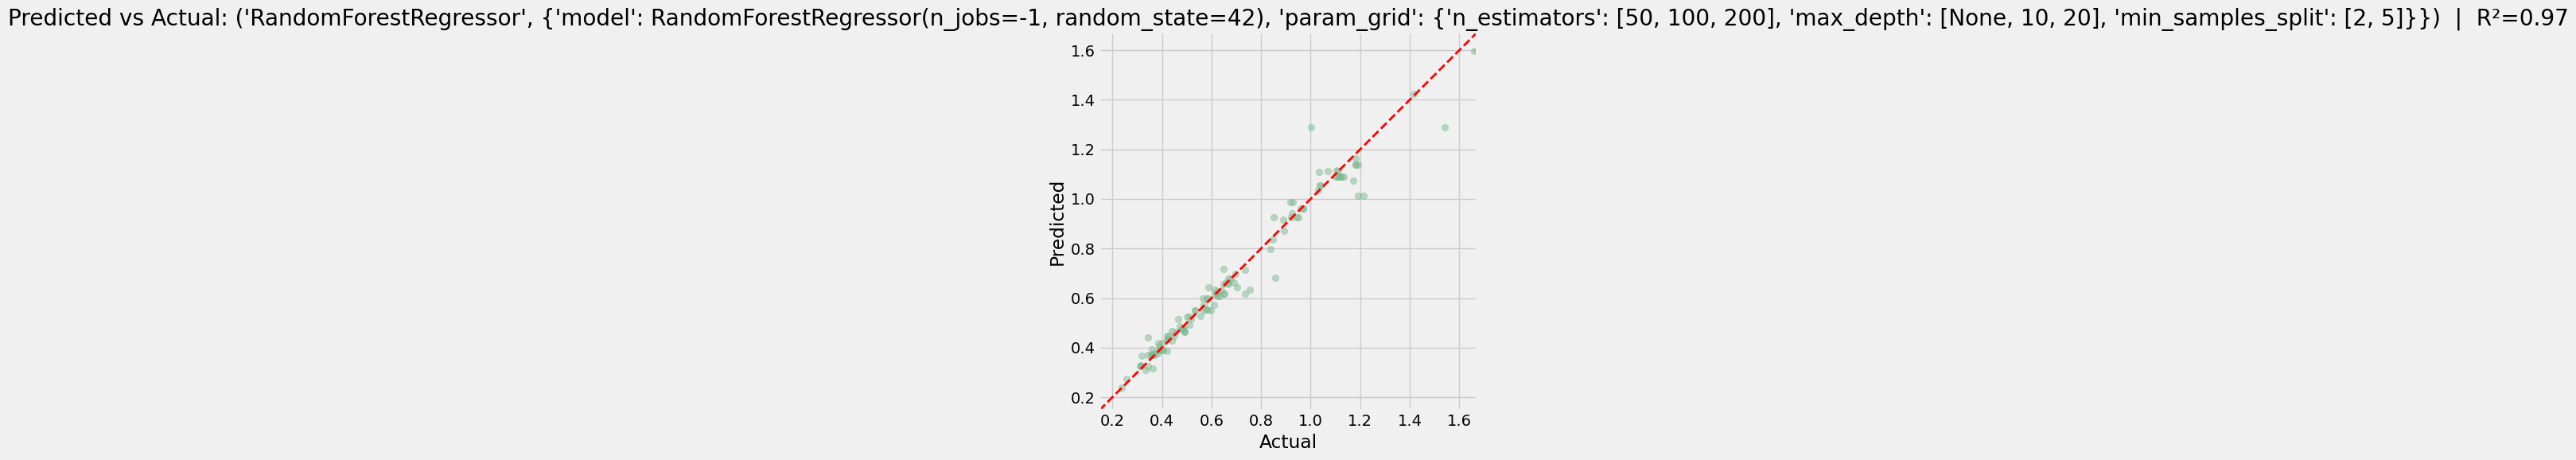

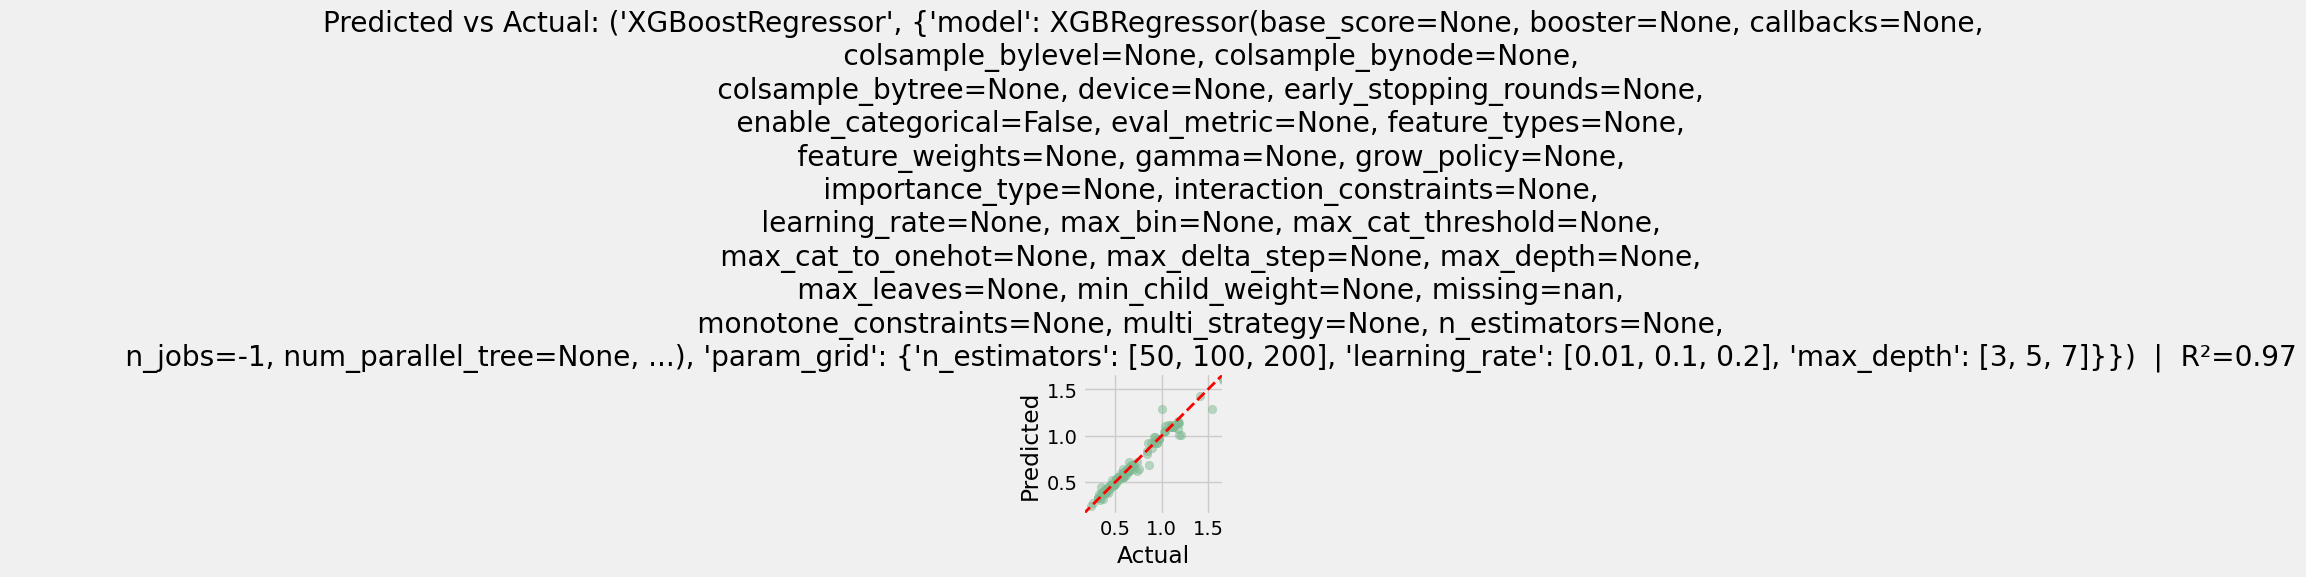

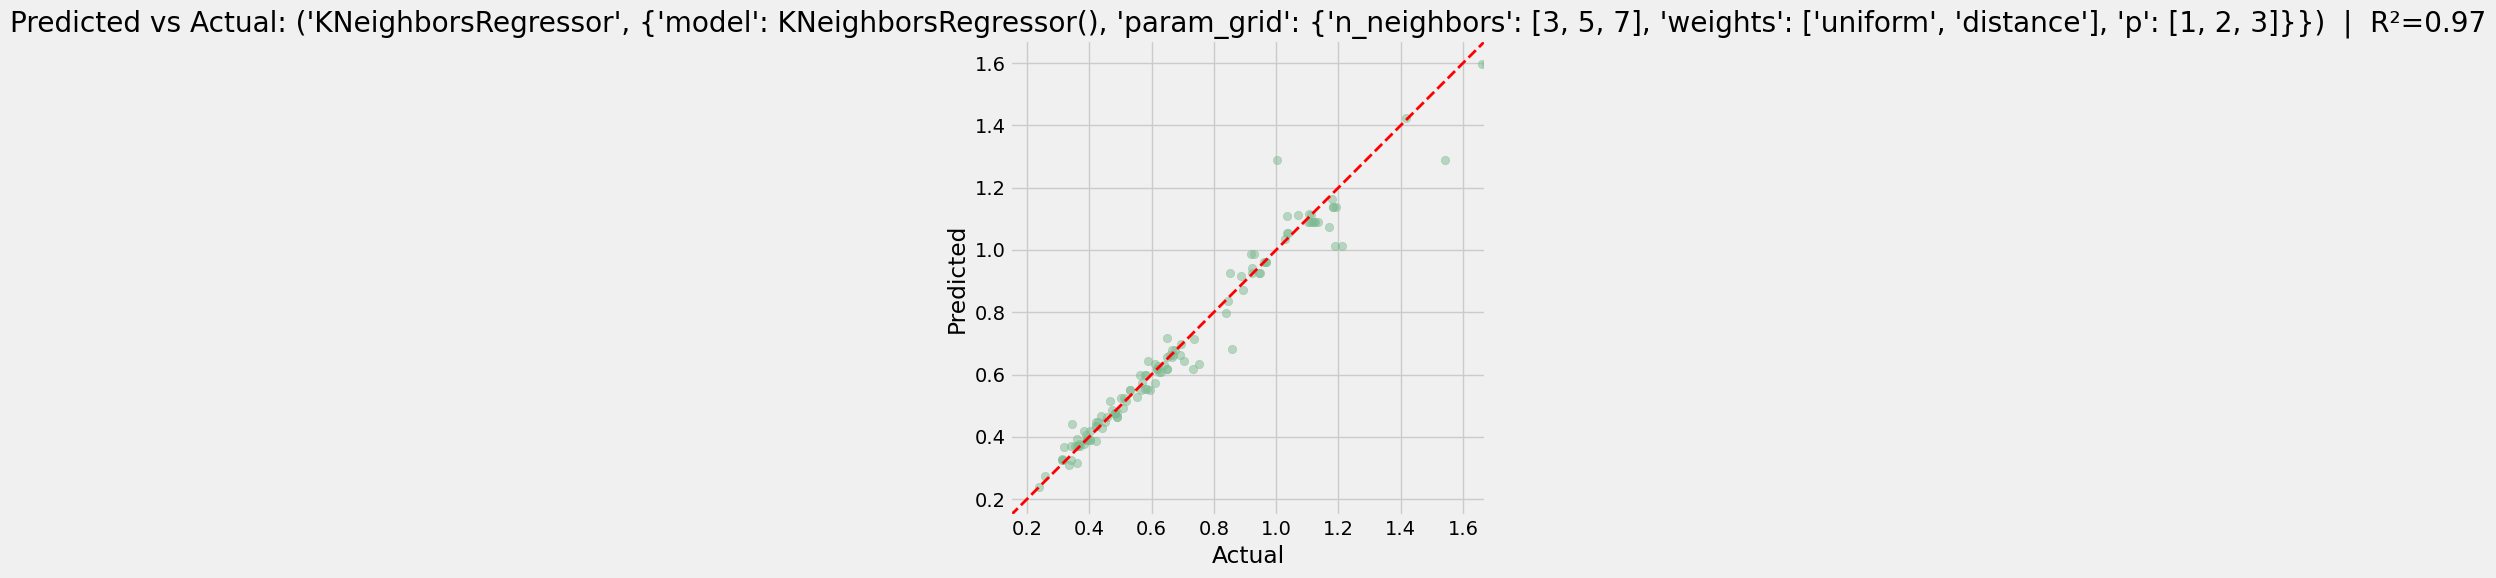

In [60]:
    for name in models.items():
        lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
    
        plt.figure(figsize=(6, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot(lims, lims, 'r--', lw=2)
        plt.xlim(lims); plt.ylim(lims)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"Predicted vs Actual: {name}  |  R²={r2:.2f}")
        plt.tight_layout()
        plt.show()


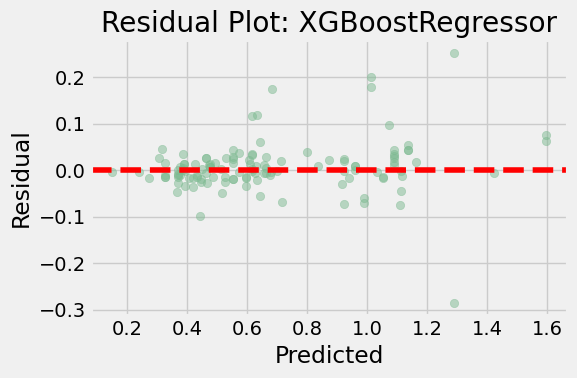

In [37]:
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title(f"Residual Plot: {name}")
plt.tight_layout()
plt.show()



In [74]:
print(models['name'])

KeyError: 'name'

In [75]:
key = list(models.)[index]
print(key

SyntaxError: incomplete input (4151695281.py, line 2)